# 0.0 Imports

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import pickle
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
import json

## 0.01 Helper Functions

In [4]:
# Apply custom format do DF
def custom_format(x):
    try:
        x = float(x)
        if x >= 1000:
            return f"{x:,.0f}"
        else:
            return f"{x:.2f}"
    except (ValueError, TypeError):
        return x

def apply_custom_format(df):
    return df.style.format({col: custom_format for col in df.columns if col != 'attributes'})

## 0.1 Loading Dataset

In [5]:
df_raw = pd.read_csv('../dataset/train.csv')
df1=df_raw.copy()

# 1.0 Data Description

In [6]:
cols_new=['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

df1.columns= cols_new

## 1.1 Data Dimension

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'. format(df1.shape[1]))

Number of rows: 381109
Number of columns: 12


## 1.2 Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Data Descriptive

In [10]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])
# styled_df1 = df1.style.format({
#     col: "{:,.0f}" for col in num_attributes.columns
# })

In [11]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std)).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T
d7 = pd.DataFrame( num_attributes.apply( lambda x: x.mode()[0])).T


# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'mode']
m_formmatted = apply_custom_format(m)
m_formmatted


,attributes,min,max,range,mean,median,std,skew,kurtosis,mode
0,id,1.00,"381,109","381,108","190,555","190,555","110,017",0.00,-1.20,1.00
1,age,20.00,85.00,65.00,38.82,36.00,15.51,0.67,-0.57,24.00
2,driving_license,0.00,1.00,1.00,1.00,1.00,0.05,-21.60,464.35,1.00
3,region_code,0.00,52.00,52.00,26.39,28.00,13.23,-0.12,-0.87,28.00
4,previously_insured,0.00,1.00,1.00,0.46,0.00,0.50,0.17,-1.97,0.00
5,annual_premium,"2,630","540,165","537,535","30,564","31,669","17,213",1.77,34.00,"2,630"
6,policy_sales_channel,1.00,163.00,162.00,112.03,133.00,54.20,-0.90,-0.97,152.00
7,vintage,10.00,299.00,289.00,154.35,154.00,83.67,0.00,-1.20,256.00
8,response,0.00,1.00,1.00,0.12,0.00,0.33,2.30,3.30,0.00


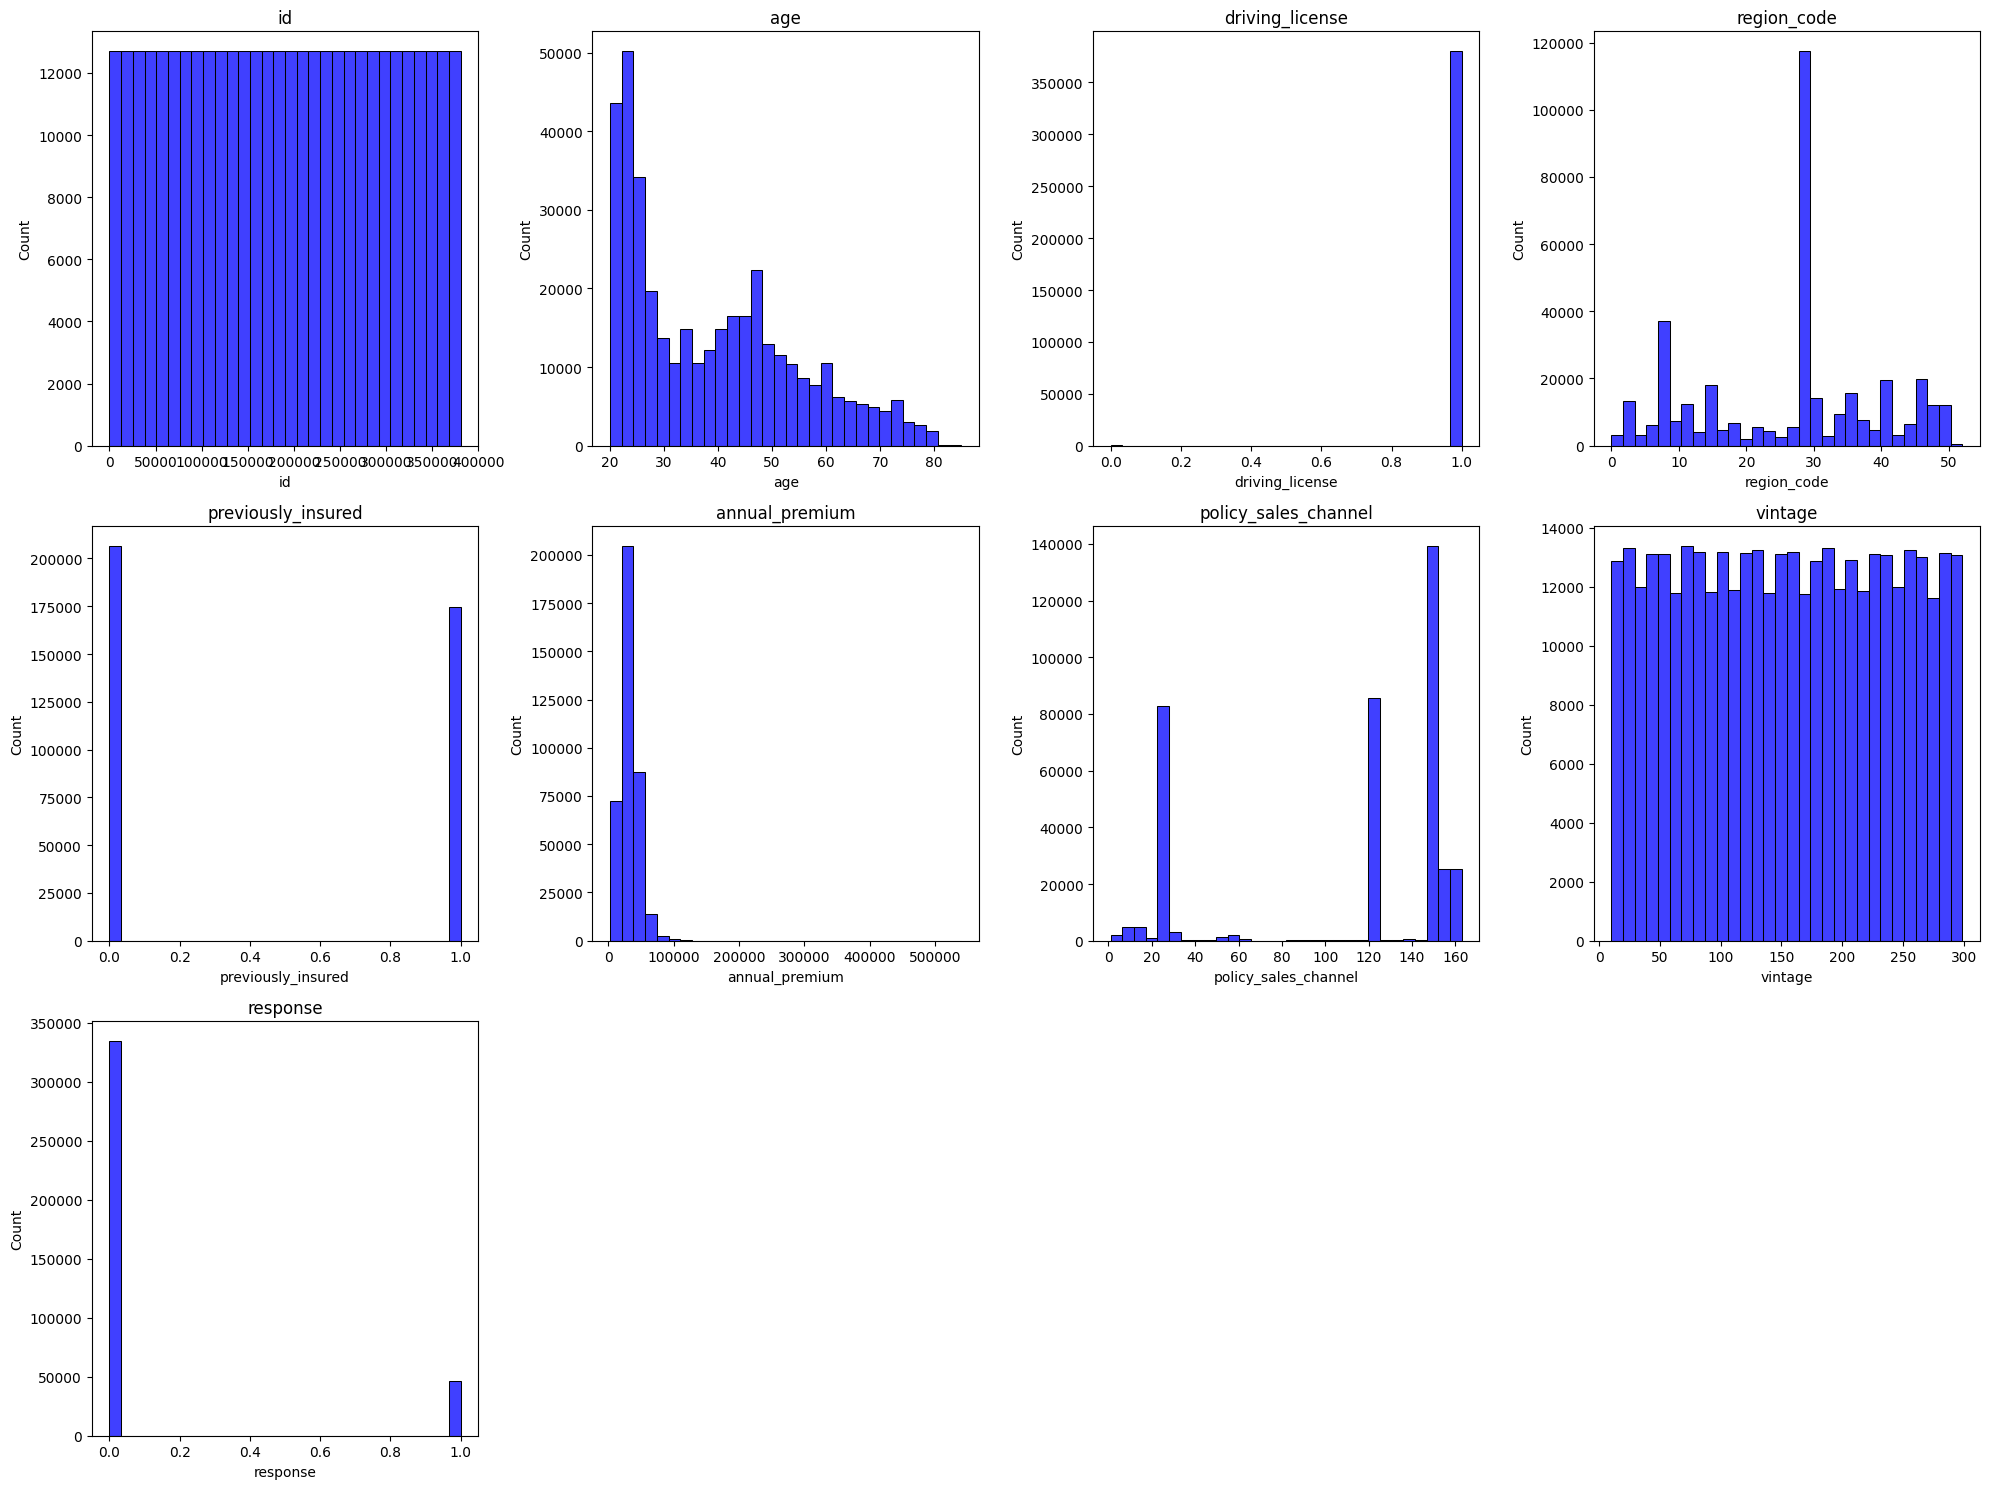

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(20, 15))

for i, column in enumerate(num_attributes.columns, 1):  
    plt.subplot(len(num_attributes.columns) // 4 + 1, 4, i)
    sns.histplot(num_attributes[column], kde=False, bins=30, color='blue')
    # Add legend and title
    plt.title(column)

plt.tight_layout()
plt.show()

# 2.0 Feature Engineering

In [13]:
df2 = df1.copy()
# Vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over 2 years' if x == '> 2 Years' 
                                              else 'between 1-2 years' if x == '1-2 Year' 
                                              else 'under 1 year')

df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' 
                                              else 0 
                                              )

# 3.0 Data Filtering

In [14]:
df3 = df2.copy()

# 4.0 EDA

In [15]:
df4 = df3.copy()

## 4.1 Bivariate Analysis

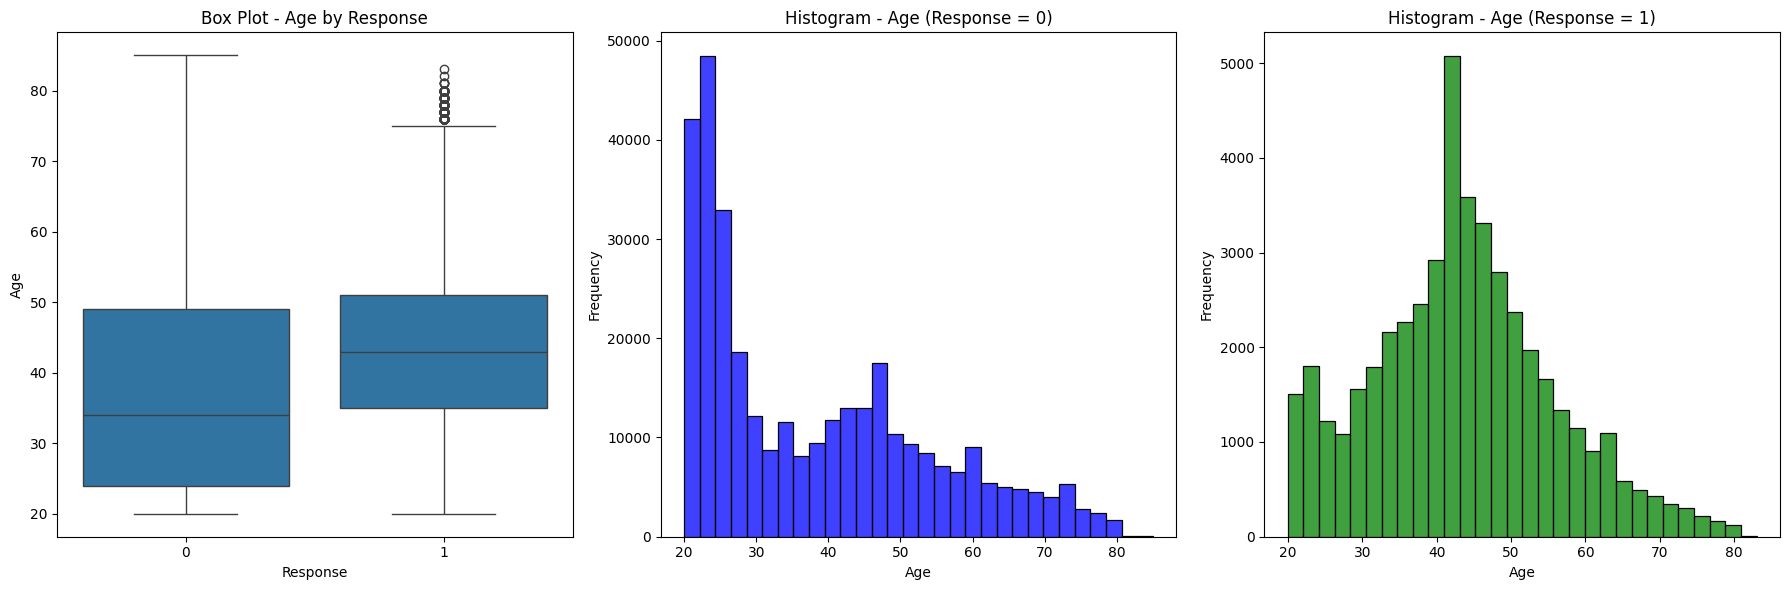

In [16]:
# Age

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(x='response', y='age', data=df4, ax=axs[0])
axs[0].set_title('Box Plot - Age by Response')
axs[0].set_xlabel('Response')
axs[0].set_ylabel('Age')

# Histogram - age for response == 0

aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00, bins=30, kde=False, color='blue', ax=axs[1])
axs[1].set_title('Histogram - Age (Response = 0)')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')

# Histogram - age for response == 1

aux01 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux01, bins=30, kde=False, color='green', ax=axs[2])
axs[2].set_title('Histogram - Age (Response = 1)')
axs[2].set_xlabel('Age')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Findings:
# customers who purchased car insurance tend to be slightly older on average.
# This indicates that middle-aged customers are more likely to buy car insurance compared to younger customers.
# Age can possibly help predict whether a customer will buy car insurance or not.

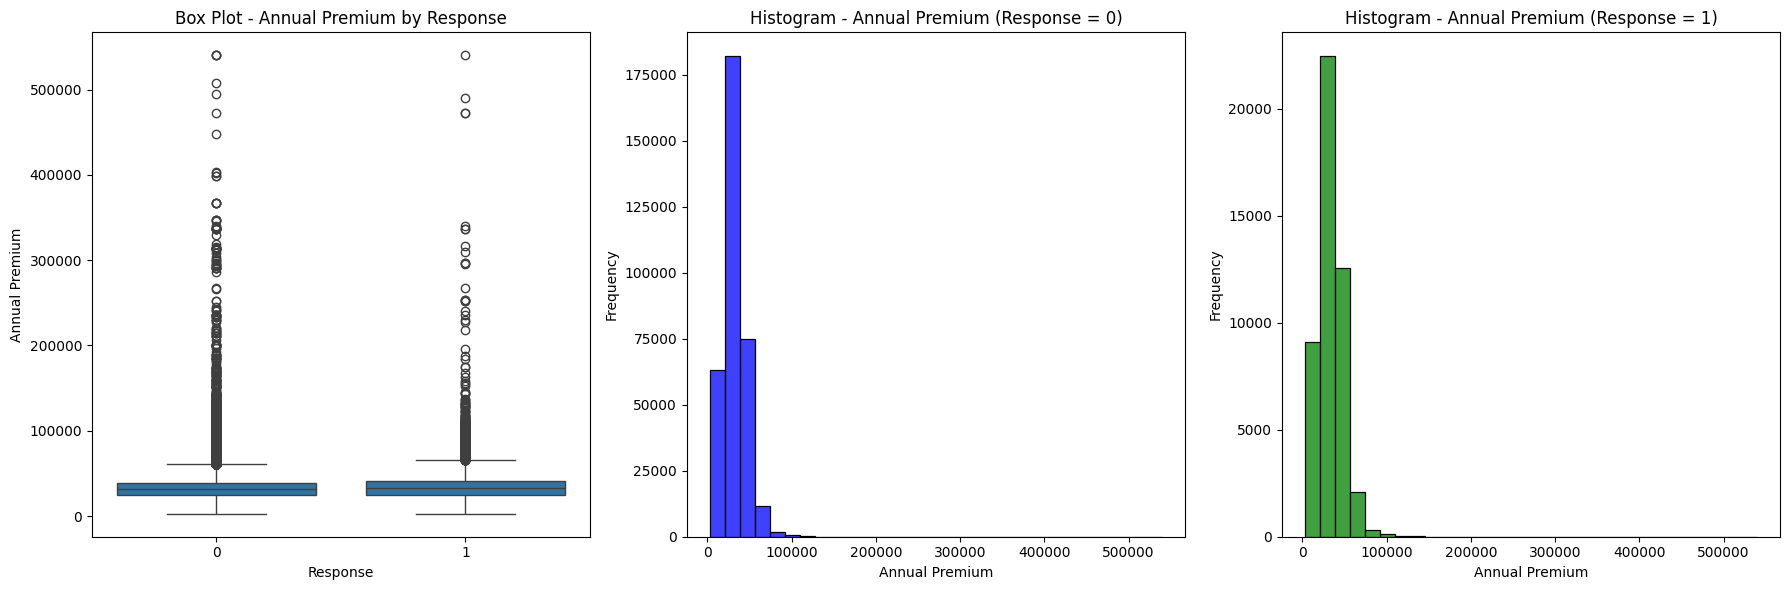

In [17]:
# annual_premium

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Box Plot - Annual Premium by Response
sns.boxplot(x='response', y='annual_premium', data=df4, ax=axs[0])
axs[0].set_title('Box Plot - Annual Premium by Response')
axs[0].set_xlabel('Response')
axs[0].set_ylabel('Annual Premium')

# Histogram - Annual Premium for response == 0
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot(aux00, bins=30, kde=False, color='blue', ax=axs[1])
axs[1].set_title('Histogram - Annual Premium (Response = 0)')
axs[1].set_xlabel('Annual Premium')
axs[1].set_ylabel('Frequency')

# Histogram - Annual Premium for response == 1
aux01 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot(aux01, bins=30, kde=False, color='green', ax=axs[2])
axs[2].set_title('Histogram - Annual Premium (Response = 1)')
axs[2].set_xlabel('Annual Premium')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Findings: Both groups also have a significant number of outliers, indicating that there are some
# customers who pay much higher premiums than the majority.
# Those who buy car insurance tend to pay a bit more on average.
# Annual Premium cannot possible predict whether a customer will buy car insurance or not. They have similar distributions.

In [18]:
# driving_license
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = (aux['driving_license'] / aux['driving_license'].sum()) * 100
aux_formmatted = apply_custom_format(aux)
aux_formmatted

# Findings: more people with driver's license are not buying car insurance.
# Not determinant at this time the relevance of this feature regarding prediction.

,response,driving_license,driving_license_perc
0,0.00,"333,628",87.73
1,1.00,"46,669",12.27


<Axes: xlabel='response', ylabel='driving_license_perc'>

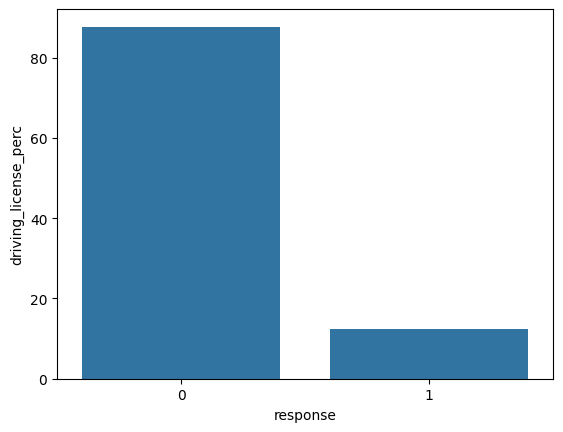

In [19]:
sns.barplot( x= 'response', y='driving_license_perc', data=aux)

<Axes: xlabel='region_code', ylabel='id'>

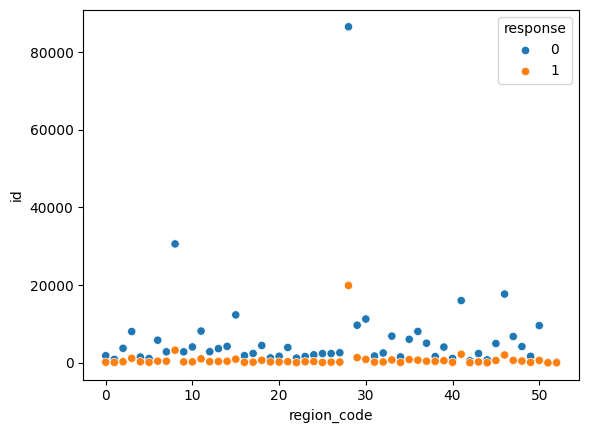

In [20]:
# region_code
aux0 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux0)

# Findings: even though region 28 has the highest number of people who bought car insurance, is not 
# possible to define as a good variable to predict if they will buy car insurance or not.
# all other regions have similar number of people who bought car insurance.

In [21]:
# previously_insured
pd.crosstab( df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
# Findings: no significant relation between previously insured and response
# most people who have insurance are not changing car insurance

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [22]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index().apply

<bound method DataFrame.apply of          vehicle_age  response  proportion
0  between 1-2 years         0    0.434285
1       under 1 year         0    0.413488
2  between 1-2 years         1    0.091328
3       over 2 years         0    0.029663
4       under 1 year         1    0.018897
5       over 2 years         1    0.012338>

<Axes: xlabel='response', ylabel='policy_sales_channel'>

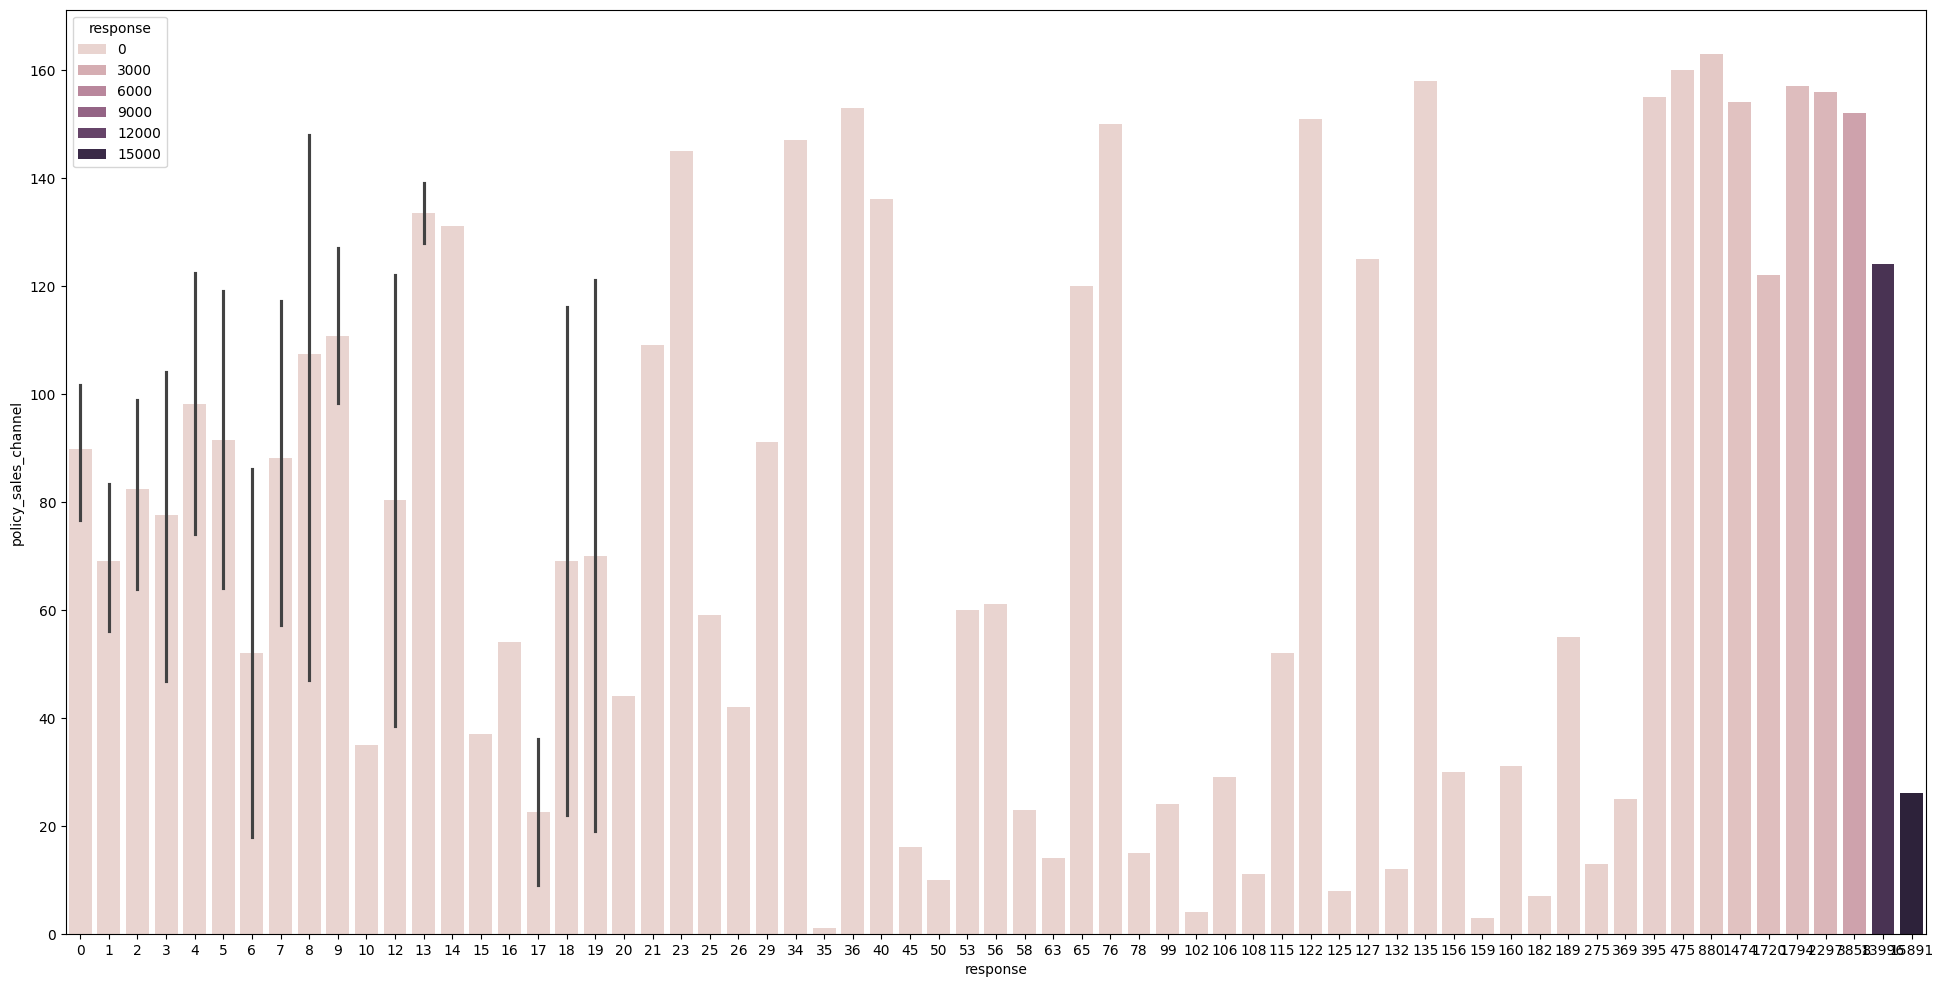

In [23]:
# policy_sales_channel
plt.figure(figsize= (24, 12))
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x = 'response', y='policy_sales_channel', hue='response', data=aux)

<Axes: xlabel='response', ylabel='vintage'>

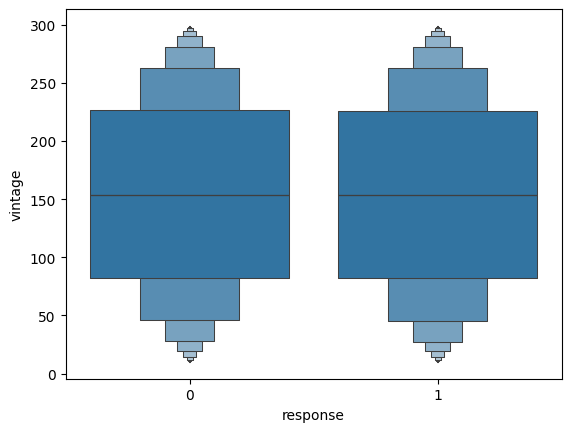

In [24]:
# vintage
sns.boxenplot(x='response', y='vintage', data=df4)

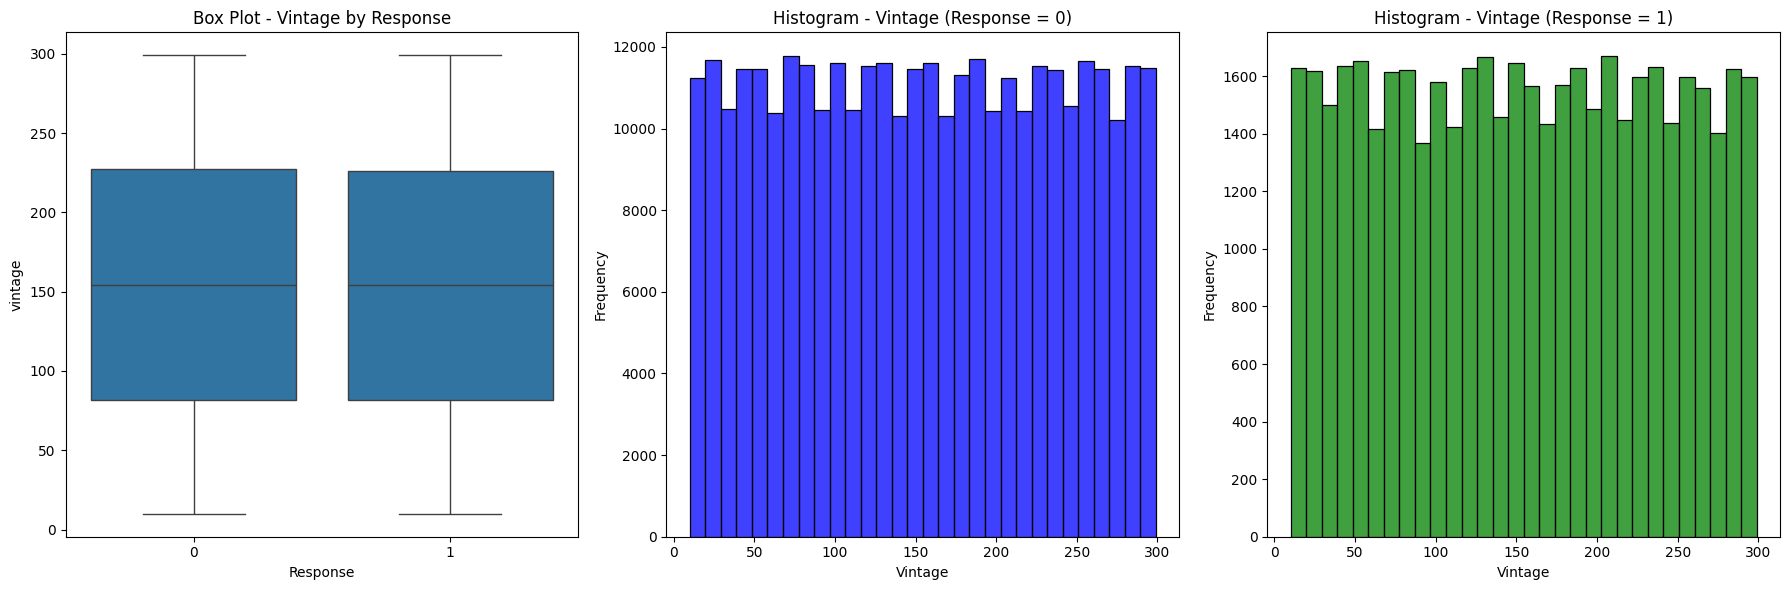

In [25]:
# vintage
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Box Plot - Vintage by Response
sns.boxplot(x='response', y='vintage', data=df4, ax=axs[0])
axs[0].set_title('Box Plot - Vintage by Response')
axs[0].set_xlabel('Response')
axs[0].set_ylabel('vintage')

# Histogram - Annual Premium for response == 0
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00, bins=30, kde=False, color='blue', ax=axs[1])
axs[1].set_title('Histogram - Vintage (Response = 0)')
axs[1].set_xlabel('Vintage')
axs[1].set_ylabel('Frequency')

# Histogram - Annual Premium for response == 1
aux01 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux01, bins=30, kde=False, color='green', ax=axs[2])
axs[2].set_title('Histogram - Vintage (Response = 1)')
axs[2].set_xlabel('Vintage')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#  Findings: no distinctive relation between vintage and responses.

# 5.0 Data Preparation

In [80]:
df5 =  df4.copy()

In [81]:
x = df4.drop( 'response', axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(x, y, test_size=0.2, random_state=32)
df5 = pd.concat([x_train, y_train], axis=1)

## 5.1 Standardization

In [82]:
ss=pp.StandardScaler()
# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump( ss, open('../features/annual_premium_scaler.pkl', 'wb') )

## 5.2 Rescaling

In [83]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump( mms_age, open('../features/age_scaler.pkl', 'wb') )
# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump( mms_vintage, open('../features/vintage_scaler.pkl', 'wb') )

## 5.3 Encoder

In [84]:
# gender - Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump( target_encode_gender, open('../features/target_encode_gender.pkl', 'wb') )

# region_code - Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump( target_encode_region_code, open('../features/target_encode_region_code.pkl', 'wb') )

# vehicle_age - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['vehicle_age'], columns=['vehicle_age'])

# policel_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:,'policy_sales_channel'] = df5[ 'policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump( fe_policy_sales_channel, open('../features/fe_policy_sales_channel.pkl', 'wb') )

## 5.4 Validation Preparation   

In [31]:
# Transformations
x_validation['age'] = x_validation['age'].astype(float)
x_validation['vintage'] = x_validation['vintage'].astype(float)

# Annual Premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values).astype(float)

# Age - converting the transformed result to float64
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values).astype(float)

# Vintage - converting the transformed result to float64
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values).astype(float)

# Gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# Region Code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# One-Hot Encode Vehicle Age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# Policy Sales Channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation.loc[:, 'policy_sales_channel'].map(fe_policy_sales_channel)

In [32]:
x_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76222 entries, 154612 to 83974
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             76222 non-null  int64  
 1   gender                         76222 non-null  object 
 2   age                            76222 non-null  float64
 3   driving_license                76222 non-null  int64  
 4   region_code                    76222 non-null  float64
 5   previously_insured             76222 non-null  int64  
 6   vehicle_damage                 76222 non-null  int64  
 7   annual_premium                 76222 non-null  float64
 8   policy_sales_channel           76222 non-null  float64
 9   vintage                        76222 non-null  float64
 10  vehicle_age_between 1-2 years  76222 non-null  bool   
 11  vehicle_age_over 2 years       76222 non-null  bool   
 12  vehicle_age_under 1 year       76222 non-null 

In [33]:
x_validation['gender']=x_validation['gender'].astype(float)
x_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76222 entries, 154612 to 83974
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             76222 non-null  int64  
 1   gender                         76222 non-null  float64
 2   age                            76222 non-null  float64
 3   driving_license                76222 non-null  int64  
 4   region_code                    76222 non-null  float64
 5   previously_insured             76222 non-null  int64  
 6   vehicle_damage                 76222 non-null  int64  
 7   annual_premium                 76222 non-null  float64
 8   policy_sales_channel           76222 non-null  float64
 9   vintage                        76222 non-null  float64
 10  vehicle_age_between 1-2 years  76222 non-null  bool   
 11  vehicle_age_over 2 years       76222 non-null  bool   
 12  vehicle_age_under 1 year       76222 non-null 

In [34]:
x_validation = x_validation.fillna(0).infer_objects(copy=False)

# 6.0 Feature Selection

## 6.1 Features Importance

In [35]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)


ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                         feature  importance
0                        vintage    0.272123
0                 annual_premium    0.244372
0                            age    0.165556
0                    region_code    0.106223
0                 vehicle_damage    0.068309
0           policy_sales_channel    0.059220
0             previously_insured    0.055826
0       vehicle_age_under 1 year    0.013018
0  vehicle_age_between 1-2 years    0.007443
0                         gender    0.004788
0       vehicle_age_over 2 years    0.002614
0                driving_license    0.000509


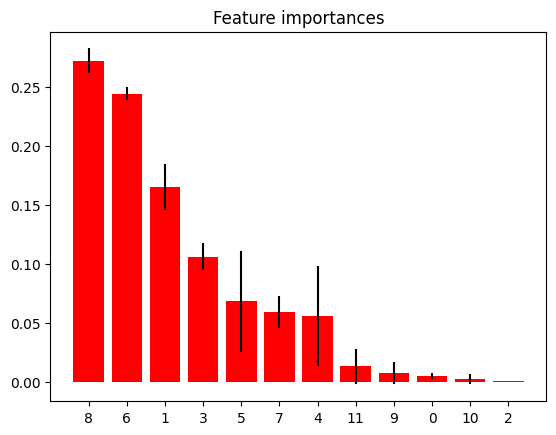

In [36]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim(-1, x_train_n.shape[1])
plt.show()


# 7.0 Machine Learning

In [37]:
cols_selected = ['annual_premium', 'vintage', 'region_code', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']
x_train = df5 [cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation

## 7.1 KNN

In [38]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - generalization power (validate dataset)
yhat_knn = knn_model.predict_proba(x_val)


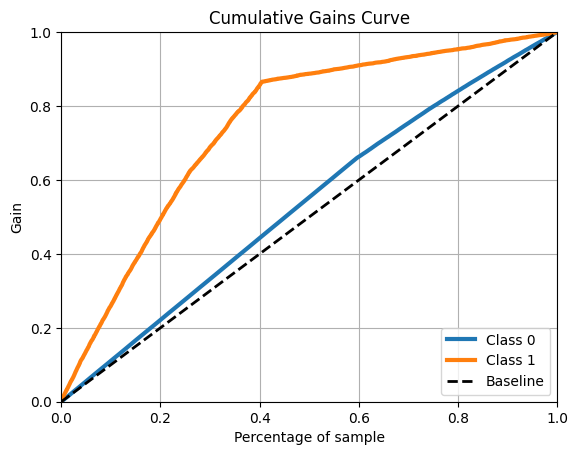

In [39]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);


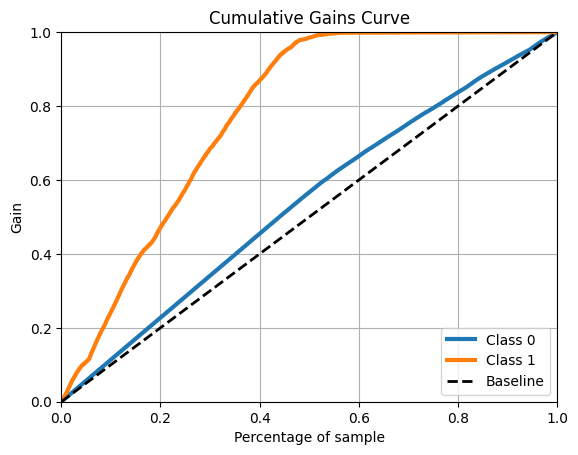

In [40]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);


## 7.2 Extra Trees

In [41]:
# Model definition
et = en.ExtraTreesClassifier(n_estimators=300, random_state=0, n_jobs=-1)

# Model fit
et.fit(x_train, y_train)

# Model predict (probability)
yhat_et = et.predict_proba(x_val)


In [42]:
# Repeated prediction (probability) - Optional, may be redundant
yhat_et = et.predict_proba(x_val)

# 8.0 Model Performance

In [43]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8[ 'score'] = yhat_knn[:,1].tolist()

# sorted clients by propensity score
df8 = df8.sort_values('score', ascending=False)

# compute precision at k


In [63]:
def precision_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data[ 'precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc [k, 'precision_at_k']

In [65]:
def recall_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data[ 'recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc [k, 'recall_at_k']

In [66]:
# compute precision at k
precision_at_50 = precision_at_k(df8, k=50)
print('Precision at k: {}'.format(precision_at_50))

# compute recall at k
recall_at_50 = recall_at_k(df8, k=50)
print('Recall at k: {}'.format(recall_at_50))

Precision at k: 0.43137254901960786
Recall at k: 0.002385082393755421


# 9.0 Deploy to Production

In [69]:
pickle.dump (lr_model, open ('../models/lr_model.pkl', 'wb'))

## 9.1 Helth Insurance Class

In [103]:
class HealthInsurance:
    def __init__(self):
        self.home_path = ''
        self.annual_premium_scaler = pickle.load(open('../src/features/annual_premium_scaler.pkl', 'rb'))
        self.age_scalar = pickle.load(open('../src/features/age_scaler.pkl', 'rb'))
        self.vintage_scalar = pickle.load(open('../src/features/vintage_scaler.pkl', 'rb'))
        self.target_encode_gender = pickle.load(open('../src/features/target_encode_gender.pkl', 'rb'))
        self.target_encode_region_code = pickle.load(open('../src/features/target_encode_region_code.pkl', 'rb'))
        self.fe_policy_sales_channel = pickle.load(open('../src/features/fe_policy_sales_channel.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        ## 1.0 Rename Columns
        cols_new = ['id', 'gender', 'age', 'region_code', 'policy_sales_channel', 'driving_license', 'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']
        df1.columns = cols_new
        return df1
        
    def feature_engineering(self, df2):
        ## 2.0 Feature Engineering
        # vehicle age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over 2 years' if x == '> 2 Years' 
                                                          else 'between 1-2 years' if x == '1-2 Year' 
                                                          else 'under 1 year')
        # vehicle damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)
        
        return df2
    
    def data_preparation(df5):
        # 3.0 Preprocessing
        # Annual Premium - Standard Scaler
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)
        
        # Age - Min Max Scaler
        df5['age'] = self.age_scalar.transform(df5[['age']].values)
        
        # Vintage - Min Max Scaler
        df5['vintage'] = self.vintage_scalar.transform(df5[['vintage']].values)
        
        # gender - Target Encoding
        df5.loc[:, 'gender'] = df5.loc[:, 'gender'].map(self.target_encode_gender)
        
        # region_code - Target Encoding
        df5.loc[:, 'region_code'] = df5.loc[:, 'region_code'].map(self.target_encode_region_code)
        
        # policy_sales_channel - Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5.loc[:, 'policy_sales_channel'].map(self.fe_policy_sales_channel)
        
        # Vehicle Age
        df5 = pd.get_dummies(df5, prefix=['vehicle_age'], columns=['vehicle_age'])
        
        # Reset Index
        df5 = df5.reset_index(drop=True)
                
        # Featuring Selection
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'policy_sales_channel', 'previously_insured', 'vehicle_damage', 'vehicle_age_over 2 years', 'vehicle_age_under 1 year']
    
        return df5 [cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict_proba(test_data)
        
        # join pred into the original data
        original_data['score'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')
    

## 9.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from health_insurance_cross_sell import HealthInsurance
# from models import lr_model

# loading model
path= '../models/'
model = pickle.load(open( path +'/lr_model.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # instantiate HealthInsurance class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype = 'application/json')
    
# Run flask app    
if __name__ == '__main__':
    # port = os.environ.get('PORT', 5000)
    app.run('0.0.0.0', port=5000, debug=True)
    

## 9.3 API Tester

In [87]:
import requests

In [88]:
#loading test dataset
df_test = x_validation
df_test[ 'response'] = y_validation

In [89]:
df_test = df_test.sample(10)

In [93]:
data = json.dumps( df_test.to_dict( orient='records' ) )

In [95]:
df_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
309772,309773,Male,38,1,3.0,1,between 1-2 years,0,26993.0,124.0,106,0
102703,102704,Female,56,1,15.0,0,between 1-2 years,0,2630.0,124.0,63,0
243898,243899,Male,29,1,15.0,1,under 1 year,0,33984.0,152.0,36,0
307340,307341,Female,24,1,30.0,1,under 1 year,0,24214.0,152.0,15,0
363216,363217,Male,66,1,20.0,0,over 2 years,1,2630.0,156.0,94,0
218928,218929,Female,21,1,11.0,1,under 1 year,0,2630.0,152.0,132,0
107166,107167,Male,62,1,28.0,0,between 1-2 years,1,90526.0,26.0,82,0
356528,356529,Female,25,1,28.0,1,under 1 year,0,23023.0,152.0,100,0
222266,222267,Male,22,1,46.0,1,under 1 year,0,27168.0,152.0,212,0
225401,225402,Female,24,1,28.0,1,under 1 year,0,2630.0,160.0,262,0


In [96]:
data = json.dumps( df_test.to_dict( orient='records' ) )

In [97]:
data

'[{"id": 309773, "gender": "Male", "age": 38, "driving_license": 1, "region_code": 3.0, "previously_insured": 1, "vehicle_age": "between 1-2 years", "vehicle_damage": 0, "annual_premium": 26993.0, "policy_sales_channel": 124.0, "vintage": 106, "response": 0}, {"id": 102704, "gender": "Female", "age": 56, "driving_license": 1, "region_code": 15.0, "previously_insured": 0, "vehicle_age": "between 1-2 years", "vehicle_damage": 0, "annual_premium": 2630.0, "policy_sales_channel": 124.0, "vintage": 63, "response": 0}, {"id": 243899, "gender": "Male", "age": 29, "driving_license": 1, "region_code": 15.0, "previously_insured": 1, "vehicle_age": "under 1 year", "vehicle_damage": 0, "annual_premium": 33984.0, "policy_sales_channel": 152.0, "vintage": 36, "response": 0}, {"id": 307341, "gender": "Female", "age": 24, "driving_license": 1, "region_code": 30.0, "previously_insured": 1, "vehicle_age": "under 1 year", "vehicle_damage": 0, "annual_premium": 24214.0, "policy_sales_channel": 152.0, "vin

In [101]:
# API Call 
#url= 'http://0.0.0.0:5000/HealthInsurance/predict'
url= 'https://health-insurance-cross-sell-z284.onrender.com/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers = header)
print('Status Code {}'.format(r.status_code))


MissingSchema: Invalid URL 'render': No scheme supplied. Perhaps you meant https://render?

In [102]:
d1 = pd.DataFrame (r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False).head()

NameError: name 'r' is not defined